In [1]:
import torch
import numpy as np
import pickle
import json
from collections import defaultdict
import argparse
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.prc import Encode, Encode_simple, Decode, KeyGen

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, set_seed
from datasets import load_dataset

In [2]:
def build_huffman_tree(frequencies):
    #using a dictionary instead of a heap
    nodes = {symbol: {"freq": freq, "left": None, "right": None, "symbol": symbol} for symbol, freq in frequencies.items()}
    while len(nodes) > 1:
        #find two least frequent nodes
        left_symbol, right_symbol = sorted(nodes, key=lambda symbol: nodes[symbol]["freq"])[:2]
        left_node = nodes.pop(left_symbol)
        right_node = nodes.pop(right_symbol)
        new_node = {"freq": left_node["freq"] + right_node["freq"], "left": left_node, "right": right_node}
        nodes[f"{left_symbol}, {right_symbol}"] = new_node

    [(root_symbol, root_node)] = nodes.items()
    return root_node

def generate_huffman_codes(tree):
    codes = {}
    def traverse(node, current_code=""):
        if node["left"] is None and node["right"] is None:
            # Store the code for the symbol, not the frequency
            codes[node["symbol"]] = current_code
            return
        traverse(node["left"], current_code + "0")
        traverse(node["right"], current_code + "1")
    traverse(tree)
    return codes

def huffman_encode(frequencies):
  tree = build_huffman_tree(frequencies)
  codes = generate_huffman_codes(tree)
  encoding = {token: codes[token] for token, freq in frequencies.items()}
  return encoding

def huffman_decode(encoding, encoded_string):
    decoding = {code: symbol for symbol, code in encoding.items()} # This line was correct
    decoded_sequence = []
    current_code = ""
    for bit in encoded_string:
        current_code += bit
        if current_code in decoding:
            decoded_sequence.append(decoding[current_code])
            current_code = ""
    return decoded_sequence

In [35]:
class BinarizedModel:
    def __init__(self, original_model, encoding_key, decoding_key, n, tokenizer=None, frequencies=None, encoding=None, decoding=None):
        """
        Args:
            original_model: The original (non-binary) language model.
            encoding_key: The key for the PRC encoding.
            tokenizer: The tokenizer for the model.
            frequencies: A dictionary mapping original tokens to frequencies.
            encoding:  A dictionary mapping original tokens to binary strings (prefix-free).
            decoding: A dictionary mapping binary strings to original tokens.
        """
        self.original_model = original_model
        self.tokenizer = tokenizer
        self.device = next(original_model.parameters()).device
        self.encoding_key = encoding_key
        self.decoding_key = decoding_key
        X_pm1 = Encode_simple(encoding_key)
        self.prc_codeword = ((1 - X_pm1) / 2).long()

        assert len(self.prc_codeword) == n
        self.n = n

        self.prc_index = 0

        assert frequencies is not None or (encoding is not None and decoding is not None)

        if frequencies is not None:
            self.generate_huffman_encoding(frequencies)
        else:
            self.encoding = encoding
            self.decoding = decoding  # Corrected: This should be the *decoding* dict
            
        # Precompute prefix mappings for optimization
        self._precompute_prefix_mappings()

    def _precompute_prefix_mappings(self):
        """
        Precompute mappings from prefixes to possible tokens for faster lookup.
        This builds a dictionary mapping each possible prefix to the set of tokens
        that could follow it.
        """
        # Initialize prefix-to-tokens mapping
        self.prefix_to_tokens = {}
        
        # For each token and its binary code
        for token_id, code in self.encoding.items():
            # Add all prefixes of this code to the mapping
            for i in range(len(code) + 1):
                prefix = code[:i]
                if prefix not in self.prefix_to_tokens:
                    self.prefix_to_tokens[prefix] = set()
                self.prefix_to_tokens[prefix].add(token_id)
                
        # Convert sets to frozen sets for efficiency
        self.prefix_to_tokens = {prefix: frozenset(tokens) for prefix, tokens in self.prefix_to_tokens.items()}
        
        # Create mapping from prefix + bit to new possible tokens
        self.prefix_extension = {}
        for prefix in self.prefix_to_tokens:
            self.prefix_extension[(prefix, '0')] = frozenset(
                token_id for token_id in self.prefix_to_tokens[prefix]
                if len(self.encoding[token_id]) > len(prefix) and self.encoding[token_id][len(prefix):len(prefix)+1] == '0'
            )
            self.prefix_extension[(prefix, '1')] = frozenset(
                token_id for token_id in self.prefix_to_tokens[prefix]
                if len(self.encoding[token_id]) > len(prefix) and self.encoding[token_id][len(prefix):len(prefix)+1] == '1'
            )

    def generate_huffman_encoding(self, frequencies):
        self.encoding = huffman_encode(frequencies)
        self.decoding = {code: token_id for token_id, code in self.encoding.items()}
        
    def predict_binary_probs(self, original_token_probs, prefix):
        """
        Optimized version that calculates the probability of the next bit being 0 or 1.
        
        For bit 0: sum probabilities of tokens whose encoding starts with prefix+'0'
        For bit 1: sum probabilities of tokens whose encoding starts with prefix+'1'
        """
        # Get tokens that could follow this prefix with a 0 or 1
        prefix_plus_zero = (prefix, '0')
        prefix_plus_one = (prefix, '1')
        
        # Get tokens that could follow this prefix with a 0
        tokens_with_zero = self.prefix_extension.get(prefix_plus_zero, frozenset())
        # Get tokens that could follow this prefix with a 1
        tokens_with_one = self.prefix_extension.get(prefix_plus_one, frozenset())
        
        # If no possible continuations, return equal probabilities
        if not tokens_with_zero and not tokens_with_one:
            assert False
        
        # Calculate probability for bit '0'
        prob_of_zero = sum(original_token_probs.get(token_id, 0) for token_id in tokens_with_zero)
        # Calculate probability for bit '1'
        prob_of_one = sum(original_token_probs.get(token_id, 0) for token_id in tokens_with_one)
        
        # Normalize to ensure they sum to 1
        total = prob_of_zero + prob_of_one
        if total > 0:
            prob_of_zero /= total
            prob_of_one /= total
        else:
            # If all tokens have zero probability, default to equal probabilities
            prob_of_zero = 0.5
            prob_of_one = 0.5
        
        prob_of_one = min(prob_of_one, 1.0)
        # For efficiency, return both probabilities
        return 1.0 - prob_of_one, prob_of_one

    def sample_binary_token(self, x_i, hat_p_i):
        """
        Samples a binary token from the biased probabilities.

        x_i is the current index in the PRC codeword.
        hat_p_i is the E[p] which specifies the distribution over the next binary token.
        """
        if hat_p_i <= 0.5:
            # t_i <- Ber(2x_i * hat_p_i)
            return np.random.binomial(1, 2 * x_i * hat_p_i)
        else:
            # t_i <- Ber(1 - 2(1 - x_i)(1 - hat_p_i))
            return np.random.binomial(1, 1 - 2 * (1 - x_i) * (1 - hat_p_i))

    def watermarked_generate(self, prompt, num_bits, debug=True):
        """
        Generates text using the watermarked, binarized model with KV-caching for improved efficiency.
        
        Args:
            prompt: The initial prompt for generation
            num_bits: The number of binary bits to generate
            debug: Whether to generate debug plots and statistics (default True for backward compatibility)
        """
        binary_tokens = []
        output_tokens = []
        output_text = ""

        # Encode the prompt and prepare for generation
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)

        # Store the hat_p_i values for debugging
        hat_p_i_values = [] if debug else None
        entropies = [] if debug else None

        # Initial forward pass to get the KV cache for the prompt
        with torch.no_grad():
            # Get the initial output and KV cache
            outputs = self.original_model(input_ids=input_ids, use_cache=True)
            past_key_values = outputs.past_key_values
            logits = outputs.logits[0, -1, :]  # Get logits for the last token
            probs = torch.softmax(logits, dim=0)
            original_token_probs = {i: probs[i].item() for i in range(len(probs))}
            entropy = -torch.sum(probs * torch.log2(probs))
            entropies.append(entropy)

        with tqdm(total=num_bits, desc="Generating bits", disable=not debug) as pbar:
            while len(binary_tokens) < num_bits:
                prefix = ""
                # loop until s becomes a valid encoding, and do not stop if eos_token is generated
                while True:
                    prob_of_zero, prob_of_one = self.predict_binary_probs(original_token_probs, prefix)

                    if debug:
                        hat_p_i_values.append(prob_of_one)

                    # Sample bit using PRC watermarking
                    x_i = self.prc_codeword[self.prc_index].item() 
                    next_bit = self.sample_binary_token(x_i, prob_of_one)
                    binary_tokens.append(next_bit)
                    self.prc_index += 1
                    if debug:
                        pbar.update(1)

                    # if we've used all the bits in the PRC codeword, reset it
                    if self.prc_index == len(self.prc_codeword):
                        if debug:
                            print("Generating new PRC codeword")
                        self.prc_index = 0
                        self.prc_codeword = (Encode(self.encoding_key) + 1) / 2

                    prefix += str(next_bit)

                    if prefix in self.decoding:
                        decoded_token_id = self.decoding[prefix] 
                        output_tokens.append(decoded_token_id)
                        decoded_str = self.tokenizer.decode([decoded_token_id])
                        output_text += decoded_str
                        
                        # Create a tensor with just the new token for the forward pass
                        next_token_tensor = torch.tensor([[decoded_token_id]], device=self.device)
                        
                        # Forward pass with KV cache
                        with torch.no_grad():
                            outputs = self.original_model(
                                input_ids=next_token_tensor,
                                past_key_values=past_key_values,
                                use_cache=True
                            )
                            # Update KV cache for next iteration
                            past_key_values = outputs.past_key_values
                            
                            # Get logits for the next token prediction
                            logits = outputs.logits[0, -1, :]
                            probs = torch.softmax(logits, dim=0)
                            original_token_probs = {i: probs[i].item() for i in range(len(probs))}
                            entropy = -torch.sum(probs * torch.log2(probs))
                            entropies.append(entropy)
                            
                        break # Exit the inner loop

                    if len(binary_tokens) >= num_bits:
                        break
                
                if len(binary_tokens) >= num_bits:
                    break

        if debug:
            print(f"Generated {len(hat_p_i_values)} binary bits.")
            # Plot histogram or print summary statistics
            plt.hist(hat_p_i_values, bins=20, range=(0, 1))
            plt.title("Distribution of hat_p_i values encountered")
            plt.xlabel("P(next_bit = 1)")
            plt.ylabel("Frequency")
            plt.savefig(f"hat_p_i_distribution.png") # Save the plot
            print(f"Saved hat_p_i distribution plot.")
            print(f"Mean hat_p_i: {np.mean(hat_p_i_values):.4f}")
            print(f"Std dev hat_p_i: {np.std(hat_p_i_values):.4f}")
            print(f"Fraction near 0.5 (|p - 0.5| < 0.1): {np.mean(np.abs(np.array(hat_p_i_values) - 0.5) < 0.1):.4f}")
            
        return output_tokens, output_text

In [36]:
def setup(n, message_length, exp_id, fpr, prc_t):
    if not os.path.exists(f'keys/{exp_id}.pkl'):  # Generate watermark key for the first time and save it to a file
        print("Generating PRC keys...")
        (encoding_key_ori, decoding_key_ori) = KeyGen(n, message_length, false_positive_rate=fpr, t=prc_t)  # Sample PRC keys
        with open(f'keys/{exp_id}.pkl', 'wb') as f:  # Save the keys to a file
            pickle.dump((encoding_key_ori, decoding_key_ori), f)
        with open(f'keys/{exp_id}.pkl', 'rb') as f:  # Load the keys from a file
            encoding_key, decoding_key = pickle.load(f)
        assert encoding_key[0].all() == encoding_key_ori[0].all()
    else:  # Or we can just load the keys from a file
        print(f'Loading PRC keys from file keys/{exp_id}.pkl')
        with open(f'keys/{exp_id}.pkl', 'rb') as f:
            encoding_key, decoding_key = pickle.load(f)
        print(f'Loaded PRC keys from file keys/{exp_id}.pkl')
    return encoding_key, decoding_key

In [37]:
parser = argparse.ArgumentParser('Args')
parser.add_argument('--prompt', type=str, default='Tell me a fantastical story about a wizard.')
parser.add_argument('--test_num', type=int, default=10)
parser.add_argument('--model_id', type=str, default='meta-llama/Llama-3.2-1B-Instruct')
# parser.add_argument('--dataset_id', type=str, default='databricks/databricks-dolly-15k')
parser.add_argument('--inf_steps', type=int, default=50)
parser.add_argument('--nowm', type=int, default=0)
parser.add_argument('--fpr', type=float, default=0.00001)
parser.add_argument('--prc_t', type=int, default=3)
parser.add_argument('--n', type=int, default=2**12)
args = parser.parse_args([])
print(args)

Namespace(prompt='Tell me a fantastical story about a wizard.', test_num=10, model_id='meta-llama/Llama-3.2-1B-Instruct', inf_steps=50, nowm=0, fpr=1e-05, prc_t=3, n=4096)


In [38]:
hf_cache_dir = '/home/lawrence/.cache/huggingface/hub'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = args.n
test_num = args.test_num
model_id = args.model_id
nowm = args.nowm
fpr = args.fpr
prc_t = 3
exp_id = f'binarize_num_{test_num}_steps_{args.inf_steps}_t_{prc_t}_fpr_{fpr}_nowm_{nowm}_n_{n}'


In [39]:
print("Loading model...")
config = AutoConfig.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'left'

    # Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

vocab_size = config.vocab_size
eos_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Model loaded on {device}")

Loading model...
Model loaded on cuda


In [40]:
random_encoding = True

In [41]:
# Get the prompt
prompt = args.prompt
print(f"Prompt: {prompt}")

# Get the encoding key
print(f"Setting up PRC keys for {exp_id}")
message_length = 0
encoding_key, decoding_key = setup(n, message_length, exp_id, fpr, prc_t)
print(f"PRC keys set up")

if not os.path.exists(f'encoding.pkl'):
    token_counts = {token_id: 0 for token_id in range(vocab_size)}
    with open("pride_and_prejudice.txt", "r", encoding="utf-8") as f:
        example_corpus = f.readlines()
    for sentence in example_corpus:
        input_ids = tokenizer.encode(sentence)
        for token_id in input_ids:
            token_counts[token_id] += 1

    encoding = huffman_encode(token_counts)
    # save encoding to file
    with open(f'encoding.pkl', 'wb') as f:
        pickle.dump(encoding, f)
else:
    with open(f'encoding.pkl', 'rb') as f:
        encoding = pickle.load(f)
print(f"Encoding loaded")

decoding = {code: token_id for token_id, code in encoding.items()}

import math
if random_encoding:
    code_length = math.ceil(math.log2(vocab_size))
    encoding = {i: format(i, f'0{code_length}b') for i in range(vocab_size)}
    decoding = {code: i for i, code in encoding.items()}

# Binarize the model
binarized_model = BinarizedModel(
    original_model=model,
    encoding_key=encoding_key,
    decoding_key=decoding_key,
    n=n,
    tokenizer=tokenizer,
    encoding=encoding,
    decoding=decoding)
print(f"Binarized model loaded")

Prompt: Tell me a fantastical story about a wizard.
Setting up PRC keys for binarize_num_10_steps_50_t_3_fpr_1e-05_nowm_0_n_4096
Loading PRC keys from file keys/binarize_num_10_steps_50_t_3_fpr_1e-05_nowm_0_n_4096.pkl
Loaded PRC keys from file keys/binarize_num_10_steps_50_t_3_fpr_1e-05_nowm_0_n_4096.pkl
PRC keys set up
Encoding loaded
Binarized model loaded


In [42]:
# Generate a bunch of texts of varying lengths
output_tokens, output_text = binarized_model.watermarked_generate(prompt, num_bits=n)
print(f"Output text: {output_text}")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [25]:
def detect_hamming_binary(binarized_model, watermarked_text_binary):
    """
    Detects if the provided binary string is watermarked, using hamming distance.
    """
    if len(watermarked_text_binary) < binarized_model.n:
        watermarked_text_binary = torch.cat([watermarked_text_binary, torch.zeros(binarized_model.n - len(watermarked_text_binary))])

    # wt(Px) < (1/2 - r^(-1/4)) * r, output 1, where P is the parity check matrix
    parity_check_matrix = binarized_model.decoding_key[1]
    r = parity_check_matrix.shape[0]
    
    # compute Px
    Px = (parity_check_matrix @ watermarked_text_binary) % 2
    
    hamming_weight = np.sum(Px)
    
    threshold = (1/2 - r**(-1/4)) * r
    # if below threshold, then detection
    result = hamming_weight < threshold
    
    return threshold, hamming_weight, result

def detect_hamming_text(binarized_model, watermarked_text):
    """
    Detects if the provided text is watermarked, using hamming distance.
    """
    # convert watermarked_text to binary string using encoding
    watermarked_text_binary = ''.join([binarized_model.encoding[token_id] for token_id in watermarked_text])
    watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)

    return detect_hamming_binary(binarized_model, watermarked_text_binary)

In [26]:
# expected r
parity_check_matrix = binarized_model.decoding_key[1]
r = parity_check_matrix.shape[0]
expected_r_2 = r/2

print(f"r: {r}")
print(f"expected r/2: {expected_r_2}")

# threshold
threshold = (1/2 - r**(-1/4)) * r
print(f"threshold: {threshold}")

r: 4013
expected r/2: 2006.5
threshold: 1502.3011279211798


In [27]:
threshold, hamming_weight, result = detect_hamming_text(binarized_model, output_tokens)
print(f"threshold: {threshold}")
print(f"hamming_weight: {hamming_weight}")
print(f"result: {result}")

threshold: 1502.3011279211798
hamming_weight: 1932.0
result: False


In [28]:
Px = (parity_check_matrix @ binarized_model.prc_codeword) % 2
print(f"sum(Px): {np.sum(Px)}")
print(binarized_model.prc_codeword.shape)
print(parity_check_matrix.shape)

sum(Px): 1979.0
torch.Size([4096])
(4013, 4096)


In [29]:
def convert_watermarked_text_to_binary(binarized_model, watermarked_text):
    watermarked_text_binary = ''.join([binarized_model.encoding[token_id] for token_id in watermarked_text])
    watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)
    return watermarked_text_binary

def corrupt_watermarked_text(binarized_model, watermarked_text, corruption_rate=0.1):
    # Convert the watermarked text to binary format
    watermarked_text_binary = convert_watermarked_text_to_binary(binarized_model, watermarked_text)
    
    # Create a mask of bits to flip based on the corruption rate
    num_bits = len(watermarked_text_binary)
    flip_mask = torch.rand(num_bits) < corruption_rate
    
    # flip the bits (0 to 1, 1 to 0)
    watermarked_text_binary[flip_mask] = 1 - watermarked_text_binary[flip_mask]
    
    return watermarked_text_binary
    

In [30]:
watermarked_text_binary = convert_watermarked_text_to_binary(binarized_model, output_tokens)
corrupted_watermarked_text_binary = corrupt_watermarked_text(binarized_model, output_tokens)
print(f"corruptions: {torch.sum(torch.abs(watermarked_text_binary - corrupted_watermarked_text_binary))}")
print(f"length: {len(watermarked_text_binary)}")

corruptions: 436.0
length: 4080


In [31]:
# compute average detection rate
corruption_rates = np.arange(0, 1, 0.1)
detection_rates = []
detection_rates_std = []
for corruption_rate in corruption_rates:
    detection_rate = []
    for i in range(1000):
        corrupted_watermarked_text_binary = corrupt_watermarked_text(binarized_model, output_tokens, corruption_rate)
        threshold, hamming_weight, result = detect_hamming_binary(binarized_model, corrupted_watermarked_text_binary)
        detection_rate.append(hamming_weight)
    detection_rates.append(np.mean(detection_rate))
    detection_rates_std.append(np.std(detection_rate))


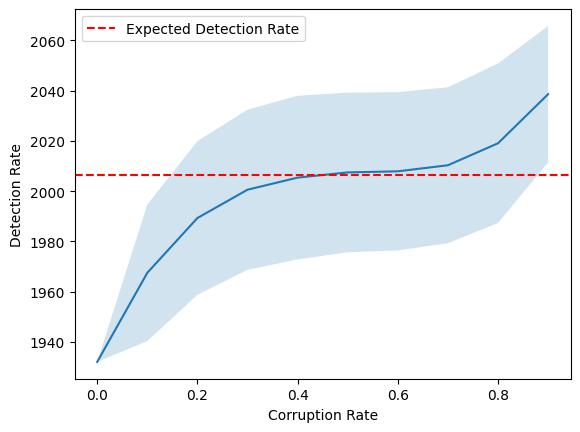

In [32]:
plt.plot(corruption_rates, detection_rates)
plt.fill_between(corruption_rates, np.array(detection_rates) - np.array(detection_rates_std), np.array(detection_rates) + np.array(detection_rates_std), alpha=0.2)
# horizontal line at r/2
plt.axhline(y=r/2, color='r', linestyle='--', label='Expected Detection Rate')
plt.xlabel("Corruption Rate")
plt.ylabel("Detection Rate")
plt.legend()
plt.show()

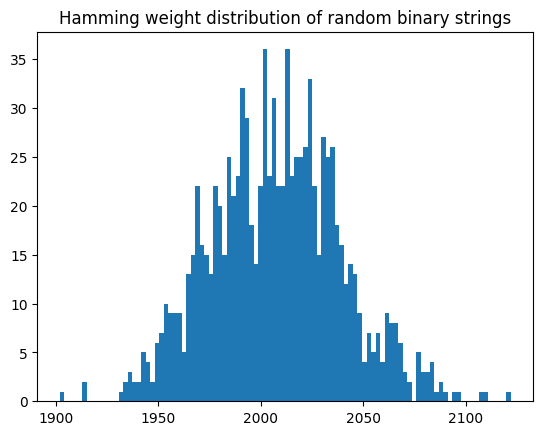

mean: 2007.345
std: 31.95487404137278


In [33]:
# generate random binary string
hamming_weights = []
for i in range(1000):
    random_binary_string = torch.rand(n)
    random_binary_string[random_binary_string < 0.5] = 0
    random_binary_string[random_binary_string >= 0.5] = 1
    threshold, hamming_weight, result = detect_hamming_binary(binarized_model, random_binary_string)
    hamming_weights.append(hamming_weight)

plt.hist(hamming_weights, bins=100)
plt.title("Hamming weight distribution of random binary strings")
plt.show()
print(f"mean: {np.mean(hamming_weights)}")
print(f"std: {np.std(hamming_weights)}")


sum(Px): 1979.0


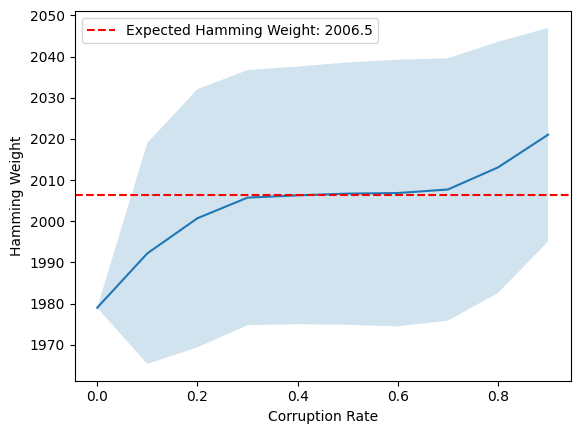

In [34]:
# check PRC codeword
P = binarized_model.decoding_key[1]
Px = (P @ binarized_model.prc_codeword) % 2
print(f"sum(Px): {np.sum(Px)}")

def corrupt_binary_string(s, corruption_rate=0.1):
    arr = np.array(list(s), dtype=int)
    mask = np.random.rand(len(arr)) < corruption_rate
    arr[mask] = 1 - arr[mask]  # flip the bits
    return ''.join(arr.astype(str))

# add noise to codeword
corruption_rates = np.arange(0, 1, 0.1)
hamming_weights = []
hamming_weights_std = []
for corruption_rate in corruption_rates:
    trials = []
    for i in range(1000):
        corrupted_codeword = corrupt_binary_string(binarized_model.prc_codeword, corruption_rate)
        Px = (P @ torch.tensor([int(bit) for bit in corrupted_codeword], dtype=float)) % 2
        hamming_weight = np.sum(Px)
        trials.append(hamming_weight)
    hamming_weights.append(np.mean(trials))
    hamming_weights_std.append(np.std(trials))

plt.plot(corruption_rates, hamming_weights)
plt.fill_between(corruption_rates, np.array(hamming_weights) - np.array(hamming_weights_std), np.array(hamming_weights) + np.array(hamming_weights_std), alpha=0.2)
# add horizontal line at expected r/2
plt.axhline(y=expected_r_2, color='r', linestyle='--', label=f'Expected Hamming Weight: {expected_r_2}')
plt.xlabel("Corruption Rate")
plt.ylabel("Hamming Weight")
plt.legend()
plt.show()
